## Confirm runtime settings

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Sep 29 09:55:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## Main Notebook

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches

import torch.nn.functional as F
from torch import nn
from tqdm.notebook import tqdm
from tqdm import tqdm
import time

# science plots requirements
!apt-get update
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super
!pip install SciencePlots
import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use('science')

device = 'cuda' if torch.cuda.is_available() else 'cpu'


Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [68.5 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:15 h

In [4]:
# data generation
def generate_seq(seq_len=20, window_len=4):
    seq = np.random.randint(0, 2, seq_len)
    zeros = np.zeros(window_len)
    ones = np.ones(window_len)
    for i in range(window_len, seq_len+1):
        sub_seq = seq[i-window_len:i]
        if np.array_equal(sub_seq, zeros) or np.array_equal(sub_seq, ones):
            return seq, 1, i-1
    return seq, 0, 0

labs = []
for i in range(10000):
    _, l, _ = generate_seq(seq_len=25, window_len=5)
    labs.append(l)
print(sum(labs)/len(labs))  # ratio of pos labels to neg


def generate_batch(size=64):
    seqs, labels, idxs = [], [], []
    for _ in range(size):
        seq, lab, idx = generate_seq(seq_len=25, window_len=5)
        seqs.append(seq)
        labels.append(lab)
        idxs.append(idx)
    X = torch.tensor(seqs, dtype=torch.float32)
    y = torch.tensor(labels, dtype=torch.float32)
    idxs = torch.tensor(idxs)
    return X, y, idxs

X, y, idxs = generate_batch()

0.5519


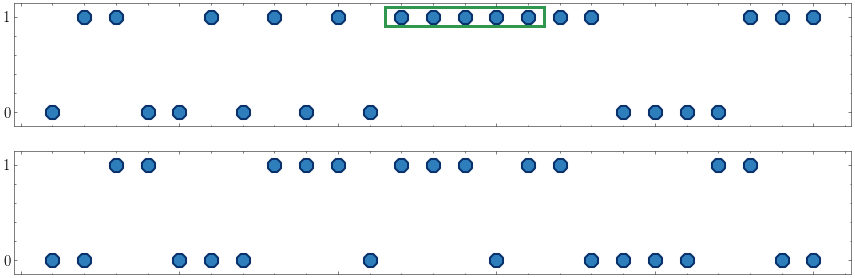

In [75]:
np.random.seed(2)
torch.manual_seed(2)

# parameters
face_col = plt.cm.Blues(0.2*(0.6/0.4) + 0.4)
edge_col = plt.cm.Blues(0.4*(0.6/0.4) + 0.4)
box_col = plt.cm.Greens(0.2*(6/4) + 0.4)


# make plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,5))
ax1.set_yticks([0,1])
ax1.tick_params(axis='y', labelsize=15)
ax1.set_xticklabels([])

seq, l, idx = generate_seq(seq_len=25, window_len=5)
# plt.step(np.arange(0, 25), seq, zorder=1)
ax1.scatter(np.arange(1, 26), seq, marker='8', s=200, facecolor=face_col, edgecolors=edge_col, linewidth=2)

rect = patches.Rectangle((idx-3-0.5, 1-0.1), 5, 0.2, linewidth=3, edgecolor=box_col, facecolor='none')
ax1.add_patch(rect)
ax1.set_ylim([-0.15, 1.15])

np.random.seed(3)
torch.manual_seed(3)
ax2.set_yticks([0,1])
ax2.tick_params(axis='y', labelsize=15)
ax2.set_xticklabels([])

seq, l, idx = generate_seq(seq_len=25, window_len=5)
# plt.step(np.arange(0, 25), seq, zorder=1)
ax2.scatter(np.arange(1, 26), seq, marker='8', s=200, facecolor=face_col, edgecolors=edge_col, linewidth=2)

ax2.set_ylim([-0.15, 1.15])

plt.savefig('seqof5_data.pdf', dpi = 1200)
plt.show()

In [6]:
torch.manual_seed(3)

class LSTM(nn.Module):
    def __init__(self, input_size, output_size, nhid, f_bias=True):
        super(LSTM, self).__init__()
        self.nhid = nhid
        self.lstm = nn.LSTM(input_size, nhid, batch_first=True)
        self.linear = nn.Linear(nhid, output_size)

    def forward(self, inputs):
        """Inputs have to have dimension (N, C_in, L_in)"""
        h0 = torch.zeros(1, inputs.size(0), self.nhid).to(device) 
        c0 = torch.zeros(1, inputs.size(0), self.nhid).to(device)
        y1, _ = self.lstm(inputs, (h0, c0))  # input should have dimension (B, S, I)
        o = self.linear(y1)
        return o

In [7]:
# CUSTOM LOSS EVALUATION 

# if obs has true label 1:
#     if pred label = 0:
#         loss = 1  [loss1]
#     if pred label = 1:
#         if model output spiked:
#             if model spike >= optimal spike:
#                 loss = (model spike - optimal spike)/(seq len)  [loss2]
#             if model spike < optimal spike:
#                 loss = 1 (this was a lucky guess)  [loss3]
#         if model output didnt spike:
#             loss = (seq len - optimal spike)/(seq len)  [loss4]
# if obs has true label 0:
#     if pred label = 0:
#         loss = 0  [loss5]
#     if pred label = 1:
#         loss = 1  [loss6]

def custom_loss(preds, spikes, y, opt_idx, seq_len=25, window_size=5):
    """
    Custom loss for evaluating performance.

    Args:
      preds (torch tensor): Raw predictions.
      spikes (torch tensor): Tensor of binary spikes.
      y (torch tensor): True labels.
      opt_idx (torch tensor): Ground truth optimal spike indexes. 
      seq_len (int): Length of the sequence.
      window_size (int): Size of window of consecutive values.
    """
    preds = torch.round(preds)
    first_spike_idx = torch.argmax(spikes, dim=1).squeeze(-1)
    normaliser = seq_len - window_size

    loss1 = (y == 1) * (preds == 0)
    loss2 = (y == 1) * (preds == 1) * (first_spike_idx != 0) * (first_spike_idx >= opt_idx)
    loss2 = loss2 * (first_spike_idx - opt_idx)/normaliser
    loss3 = (y == 1) * (preds == 1) * (first_spike_idx != 0) * (first_spike_idx < opt_idx)
    loss4 = (y == 1) * (preds == 1) * (first_spike_idx == 0) * (seq_len - opt_idx)/normaliser
    loss5 = torch.tensor([0])
    loss6 = (y == 0) * (preds == 1)
    loss_ls = [loss1, loss2, loss3, loss4, loss5, loss6]
    total_loss = np.sum([torch.sum(loss).item() for loss in loss_ls])/y.size(0)
    return total_loss

In [8]:
# helper functions 

def gather_spiking_preds(spikes, out, last_idx=24):
      """
      Gather predictions based on first spike or final output if no spike
      occurs. 

      Args:
          spikes (torch tensor): Tensor of binary spikes.
          out (torch tensor): Tensor of all model predictions.
          y (torch tensor)
          last_idx (int): Index of the final element in the sequence.

      Returns:
          Torch tensor: Outputs at these spiking values.
          Int: Number of observations in which no spike occured.
      """
      first_spike_idx = torch.argmax(spikes, dim=1, keepdim=True)
      no_spike_count = torch.sum(first_spike_idx == 0).item()
      # replace no spike with last idx for prediction
      first_spike_idx[first_spike_idx == 0] = last_idx
      preds = torch.gather(out, 1, first_spike_idx)  
      preds = preds.squeeze(-1).squeeze(-1)
      return preds, no_spike_count



In [9]:
# calculate mean spike time for both classes
def calc_mean_spike_times(spikes, y):
    first_spike_idx = torch.argmax(spikes, dim=1).squeeze(-1)
    class_0_spikes = first_spike_idx[(first_spike_idx > 0) * (y == 0)]
    class_1_spikes = first_spike_idx[(first_spike_idx > 0) * (y == 1)]
    class_0_mean = class_0_spikes.sum()/class_0_spikes.size(0)
    class_1_mean = class_1_spikes.sum()/class_1_spikes.size(0)
    return class_0_mean.item(), class_1_mean.item()

# calculate average lag between optimal spike and observed spike
def calc_mean_lag(spikes, preds, y, opt_idx):
    first_spike_idx = torch.argmax(spikes, dim=1).squeeze(-1)
    preds = torch.round(preds)
    spiking_obs = (y == 1) * (preds == 1) * (first_spike_idx != 0) 
    lags = first_spike_idx[spiking_obs] - opt_idx[spiking_obs]
    early_spikes = torch.sum(lags < 0).item()
    lags = lags[lags >= 0]  # remove early spikes
    mean_lag = (lags.sum()/lags.size(0)).item()
    return mean_lag, early_spikes


In [86]:
torch.repeat_interleave(torch.tensor([24]), BATCH_SIZE).shape

torch.Size([128])

In [130]:
model = LSTM(1, 1, 125)
model.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=0.0003)
criterion = torch.nn.BCELoss()
s = nn.Sigmoid()

NUM_TRAIN_EXAMPLES = 1000000
BATCH_SIZE = 128
VALIDATION_SIZE = 2000
VALIDATION_FREQ = 50
PATH = '/model_weights'

best_loss = 99999
loss_ls = []
spiking_acc_ls = []
custom_loss_ls = []
class_0_spike_times_ls = []
class_1_spike_times_ls = []
mean_lag_ls = []
early_spike_count_ls = []
num_batches = int(np.ceil(NUM_TRAIN_EXAMPLES/BATCH_SIZE))
seq_lens = torch.repeat_interleave(torch.tensor([24]), BATCH_SIZE).unsqueeze(-1).unsqueeze(-1).to(device)
print('################## TRAINING ##################')
print('Training {} examples in batches of size {}'.format(NUM_TRAIN_EXAMPLES, BATCH_SIZE))
print(f'resulting in {num_batches} batches')
print('##############################################\n')

time.sleep(0.2)
for i in tqdm(range(num_batches)):
    ######################## TRAIN A BATCH ########################
    # generate some training data 
    X, y, idxs = generate_batch(BATCH_SIZE)
    X, y = X.to(device), y.to(device)
    X.unsqueeze_(-1)
    
    # learn through network
    model.train()
    optimiser.zero_grad()
    out = model(X)
    out = s(out)
    
    # grab indixes of first spikes
    # with torch.no_grad():
    #     spikes = ((out < 0.05) * 1) + ((out > 0.95) * 1)
    #     first_spike_idx = torch.argmax(spikes, dim=1, keepdim=True)
    #     first_spike_idx[first_spike_idx == 0] = 24  # replace no spike with last idx

        
    # preds = torch.gather(out, 1, first_spike_idx) 
    preds = torch.gather(out, 1, seq_lens)  
    preds = preds.squeeze(-1).squeeze(-1)
    
    loss = criterion(preds, y)
    loss_ls.append(loss.item())
    loss.backward()
    optimiser.step()
    
    ######################## VALIDATION SET ########################
    if i % VALIDATION_FREQ == 0:
      model.eval()
      with torch.no_grad():
          X, y, opt_idx = generate_batch(VALIDATION_SIZE)
          X, y, opt_idx = X.to(device), y.to(device), opt_idx.to(device)
          X.unsqueeze_(-1)
          out = model(X)
          out = s(out)
          
          # generate tensor of spikes
          spikes = ((out < 0.05) * 1) + ((out > 0.95) * 1)
          preds, _ = gather_spiking_preds(spikes, out)

          # spiking accuracy
          spiking_acc_val = (torch.sum(y == torch.round(preds))/y.size(0)).item()
          spiking_acc_ls.append(spiking_acc_val)

          # custom loss score
          custom_loss_val = custom_loss(preds, spikes, y, opt_idx)
          custom_loss_ls.append(custom_loss_val)

          # store mean spike times
          mean_spike_times = calc_mean_spike_times(spikes, y)
          class_0_spike_times_ls.append(mean_spike_times[0])
          class_1_spike_times_ls.append(mean_spike_times[1])

          # evaluate mean lag between optimal and predicted spikes
          mean_lag, early_spike_count = calc_mean_lag(spikes, preds, y, opt_idx)
          mean_lag_ls.append(mean_lag)
          early_spike_count_ls.append(early_spike_count)

          # save model if better than current best
          if (custom_loss_val < best_loss) and (i > num_batches * 0.9):
              # save the model 
              best_loss = custom_loss_val
              torch.save(model.state_dict(), PATH)

time.sleep(0.2)    
    
    
print('\nFinal loss:', best_loss)

################## TRAINING ##################
Training 1000000 examples in batches of size 128
resulting in 7813 batches
##############################################



100%|██████████| 7813/7813 [04:22<00:00, 29.82it/s]



Final loss: 0.400375


torch.Size([128, 1, 1])

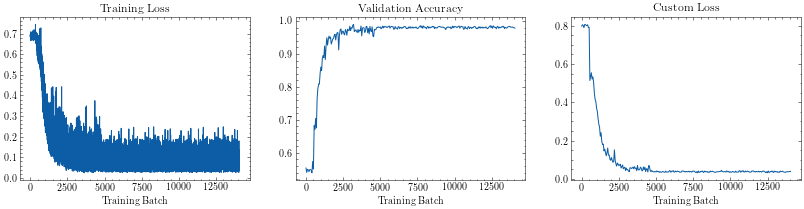

In [115]:
plt.figure(figsize=(14,3))
plt.subplot(1, 3, 1)
plt.plot(loss_ls)
plt.xlabel('Training Batch')
plt.title('Training Loss')

plt.subplot(1, 3, 2)
xvals = np.arange(len(spiking_acc_ls)) * VALIDATION_FREQ
plt.plot(xvals, spiking_acc_ls)
plt.xlabel('Training Batch')
plt.title('Validation Accuracy')

plt.subplot(1, 3, 3)
plt.plot(xvals, custom_loss_ls)
plt.xlabel('Training Batch')
plt.title('Custom Loss')

plt.show()

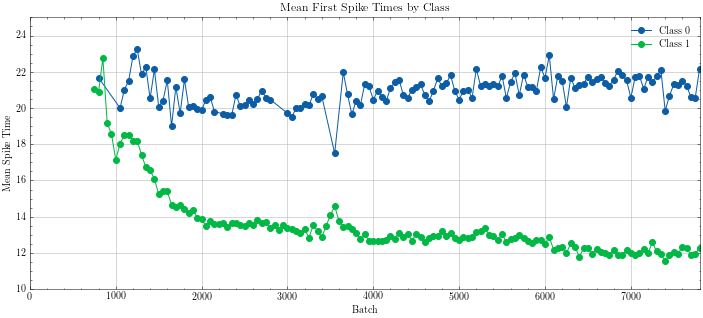

In [12]:
# plot the average first spike times by class during training (of observations that do spike)
plt.figure(figsize=(12,5))
xvals = np.arange(len(class_0_spike_times_ls)) * VALIDATION_FREQ

class_0_spike_times_arr = np.array(class_0_spike_times_ls)
mask_0 = class_0_spike_times_arr > 0
plt.xlim(0, len(xvals))
plt.plot(xvals[mask_0], class_0_spike_times_arr[mask_0], linestyle='-',
         marker='o', label='Class 0')

class_1_spike_times_arr = np.array(class_1_spike_times_ls)
mask_1 = class_1_spike_times_arr > 0
plt.xlim(0, xvals[-1])
plt.plot(xvals[mask_1], class_1_spike_times_arr[mask_1], linestyle='-',
         marker='o', label='Class 1')

plt.title('Mean First Spike Times by Class')
plt.ylabel('Mean Spike Time')
plt.xlabel('Batch')
plt.ylim(10,25)
plt.grid()
plt.legend(loc='best')
plt.show()

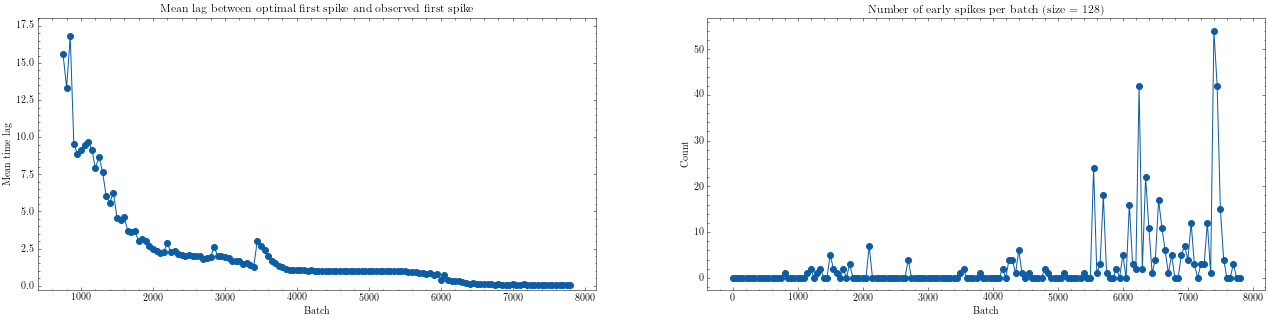

In [13]:
# plot lag between optimal first spike and observed first spike on observations
# in class 1 that did spike and did not spike early
plt.figure(figsize=(22,5))
plt.subplot(1, 2, 1)
xvals = np.arange(len(mean_lag_ls)) * VALIDATION_FREQ
mean_lag_arr = np.array(mean_lag_ls)
mask = mean_lag_arr > 0
plt.plot(xvals[mask], mean_lag_arr[mask], linestyle='-',
         marker='o', label='Label')
plt.ylim(-0.3,18)
plt.ylabel('Mean time lag')
plt.xlabel('Batch')
plt.title('Mean lag between optimal first spike and observed first spike')
# plt.show()

plt.subplot(1, 2, 2)
plt.plot(xvals, early_spike_count_ls, linestyle='-',
         marker='o', label='Label')
plt.ylabel('Count')
plt.xlabel('Batch')
plt.title(f'Number of early spikes per batch (size = {BATCH_SIZE})')
plt.show()

In [131]:
np.random.seed(1)
torch.manual_seed(1)

# load best model and evaluate on test set
model = LSTM(1, 1, 125)
model.load_state_dict(torch.load(PATH))
model.to(device)

######################## TEST SET ########################
TEST_SIZE = 10000
model.eval()
with torch.no_grad():
    X, y, opt_idx = generate_batch(TEST_SIZE)
    X, y, opt_idx = X.to(device), y.to(device), opt_idx.to(device)
    X.unsqueeze_(-1)
    out = model(X)
    out = s(out)

    # generate tensors of spikes and preds
    spikes = ((out < 0.05) * 1) + ((out > 0.95) * 1)
    preds, no_spike_count = gather_spiking_preds(spikes, out)

    # spiking accuracy
    spike_acc = torch.sum(y == torch.round(preds))/y.size(0)
    # final output accuracy
    reg_acc = torch.sum(torch.round(out[:,-1].squeeze(-1)) == y)/y.size(0)
    # custom loss value
    custom_loss_val = custom_loss(preds, spikes, y, opt_idx)
    
print('Final output accuracy:', reg_acc.item())
print('Accuracy if evaluated on first spike:', spike_acc.item())
print(f'(including {no_spike_count} observations with no spikes)')
print('Custom loss:', custom_loss_val)


Final output accuracy: 1.0
Accuracy if evaluated on first spike: 0.5819000005722046
(including 0 observations with no spikes)
Custom loss: 0.426375


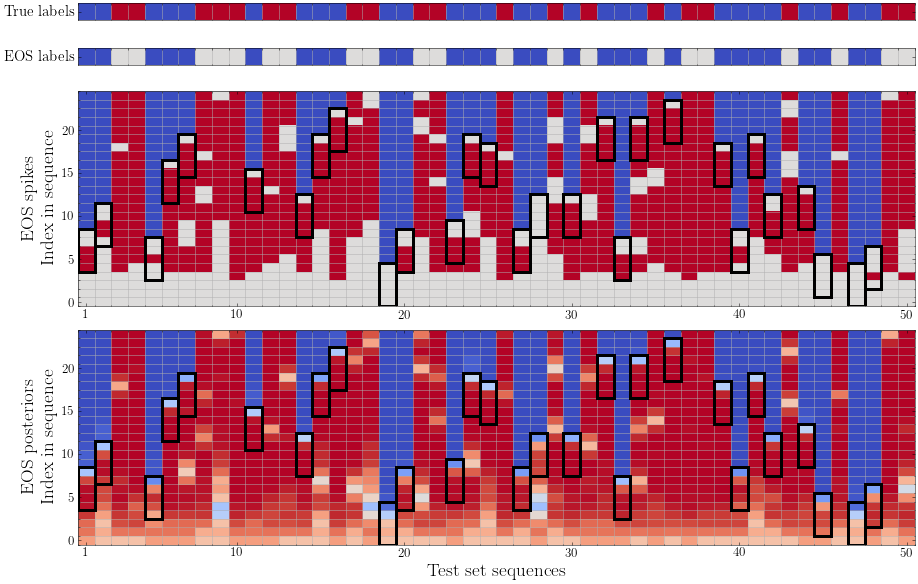

In [133]:
# POSTERIOR PLOT

# parameters
text_size = 15
tick_label_size = 13
show_full = True
model = 'EOS'  # 'RC' or 'EOS'

num_obs = 50
# gather data
post = out[:num_obs].cpu().numpy().squeeze(-1).T
labels = y[:num_obs].unsqueeze(0).cpu().numpy()
opt_spike = opt_idx[:num_obs].cpu().numpy()
spikes_out = ((out < 0.05) * -1) + ((out > 0.95) * 1)
spikes_out = spikes_out[:num_obs].cpu().numpy().squeeze(-1).T
first_spike_idx = torch.argmax(spikes, dim=1, keepdim=True)
first_spike_idx[first_spike_idx == 0] = 25  # to do maybe
first_spike_idx = first_spike_idx.squeeze().squeeze()
first_spikes = first_spike_idx[:num_obs].cpu().numpy()
preds = []
# gather predictions
for idx in range(num_obs):
  # no spike
  if first_spike_idx[idx] == 25:
    preds.append(0.5)
  else:
    if model == 'RC':
      pred = int(np.round(post[first_spikes[idx],idx]))
      preds.append(pred)
    else:
      if labels[0,idx] == 0:
        preds.append(0.5)
      else:
        pred = (np.max(post[:,idx]) > 0.95)*1
        preds.append(pred)


# only show up to first spike
if not show_full:
  for idx in range(num_obs):
    spikes_out[first_spikes[idx]+1:,idx] = 0
    post[first_spikes[idx]+1:,idx] = 0.5
  

# make plot
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(15,10), gridspec_kw={'height_ratios': [1,1,10,10]})
# true labels
ax0.imshow(labels*-1, cmap='coolwarm')
ax0.set_yticks([0])
ax0.set_xticks([])
ax0.tick_params(axis='y', labelsize=text_size)
ax0.set_yticklabels(['True labels'])
ax0.set_xticks(np.arange(-.5, num_obs, 1), minor=True)
ax0.set_axisbelow(True)
ax0.grid(which='minor')

# model predictions
ax1.imshow(np.array(preds)[None,:]*-1, cmap='coolwarm', vmin=-1, vmax=0)
ax1.set_yticks([0])
ax1.set_xticks([])
ax1.tick_params(axis='y', labelsize=text_size)
ax1.set_yticklabels([f'{model} labels'])
ax1.set_xticks(np.arange(-.5, num_obs, 1), minor=True)
ax1.set_axisbelow(True)
ax1.grid(which='minor')

# spikes
ax2.imshow(spikes_out*-1, origin='lower', aspect='auto', cmap='coolwarm')
for idx in range(num_obs):
  if labels[0,idx] == 1:      
    rect = patches.Rectangle((idx-0.5, opt_spike[idx]-4-0.5), 1, 5, linewidth=3, edgecolor='black', facecolor='none')
    ax2.add_patch(rect)
ax2.set_ylabel(f'{model} spikes\nIndex in sequence', size=text_size+4)
# ax2.set_xlabel('Test set sequences', size=text_size+4)
ax2.set_xticks([0,9,19,29,39,49])
ax2.tick_params(axis='x', labelsize=tick_label_size)
ax2.set_xticklabels([1,10,20,30,40,50])
ax2.tick_params(axis='y', labelsize=tick_label_size)
ax2.set_xticks(np.arange(-.5, num_obs, 1), minor=True)
ax2.set_yticks(np.arange(-.5, 25, 1), minor=True)
ax2.set_axisbelow(True)
ax2.grid(which='minor')

# posteriors
ax3.imshow(post*-1, origin='lower', aspect='auto', cmap='coolwarm')
for idx in range(num_obs):
  if labels[0,idx] == 1:      
    rect = patches.Rectangle((idx-0.5, opt_spike[idx]-4-0.5), 1, 5, linewidth=3, edgecolor='black', facecolor='none')
    ax3.add_patch(rect)
ax3.set_ylabel(f'{model} posteriors\nIndex in sequence', size=text_size+4)
ax3.set_xlabel('Test set sequences', size=text_size+4)
ax3.set_xticks([0,9,19,29,39,49])
ax3.tick_params(axis='x', labelsize=tick_label_size)
ax3.set_xticklabels([1,10,20,30,40,50])
ax3.tick_params(axis='y', labelsize=tick_label_size)
ax3.set_xticks(np.arange(-.5, num_obs, 1), minor=True)
ax3.set_yticks(np.arange(-.5, 25, 1), minor=True)
ax3.set_axisbelow(True)
ax3.grid(which='minor')

plt.savefig('spike_plot.pdf', dpi = 1200)
plt.show()

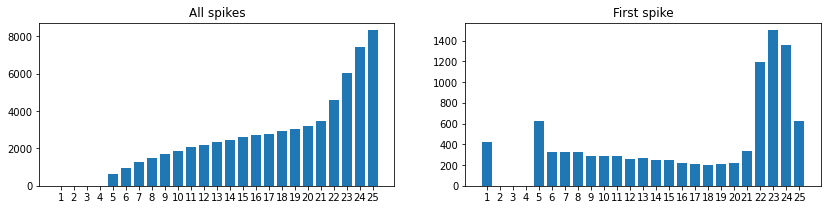

In [ ]:
# plot when all spikes occur and first spike occurs across the sequence
# Note: first spike at index 1 refers to observations that did not spike
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.bar(x=list(range(1,26)), height=spikes.cpu().sum(axis=0))
plt.title('All spikes')
plt.xticks(list(range(1,26)))

plt.subplot(1, 2, 2)
first_spike_idx = torch.argmax(spikes, dim=1).squeeze(-1)
values, counts = first_spike_idx.unique(return_counts=True)
heights = torch.zeros(25)
for i, v in enumerate(values):
    heights[v] = counts[i]
plt.bar(x=list(range(1,26)), height=heights)
plt.title('First spike')
plt.xticks(list(range(1,26)))

plt.show()

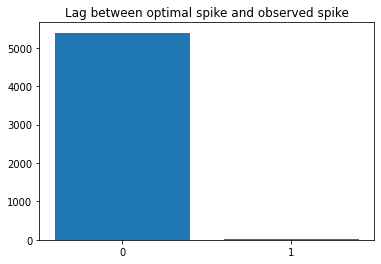

In [ ]:
# of the observations that should spike, what is the delay
first_spike_idx = torch.argmax(spikes, dim=1).squeeze(-1)
preds = torch.round(preds)
spiking_obs = (y == 1) * (preds == 1) * (first_spike_idx != 0) 
lags = first_spike_idx[spiking_obs] - opt_idx[spiking_obs]
values, counts = lags.unique(return_counts=True)
plt.bar(x=values.cpu(), height=counts.cpu())
plt.title('Lag between optimal spike and observed spike')
plt.xticks(values.cpu())
plt.show()

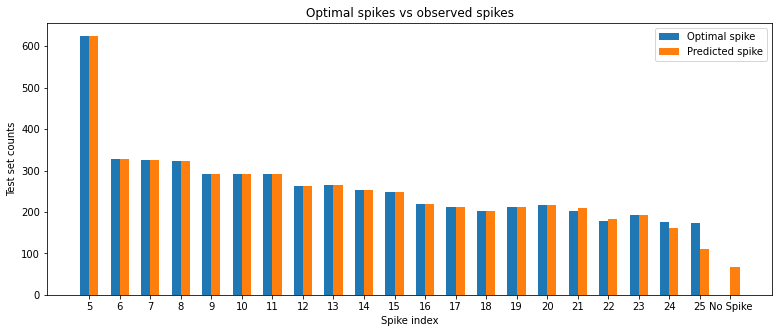

In [ ]:
# optimal spike time vs observed spike time

N = 22

# Data on X-axis

# Specify the values of blue bars (height)
values_opt, counts_opt = opt_idx[y == 1].unique(return_counts=True)
blue_bar = np.zeros(25 - 4)
cnt_to_append = 0
for val, cnt in zip(values_opt, counts_opt):
  if val > 0:
    blue_bar[val - 4] = cnt.item()
  else:
    cnt_to_append = cnt.item()
blue_bar = np.append(blue_bar, cnt_to_append)

# Specify the values of orange bars (height)
values_pred, counts_pred = first_spike_idx[y == 1].unique(return_counts=True)
orange_bar = np.zeros(25 - 4)
cnt_to_append = 0
for val, cnt in zip(values_pred, counts_pred):
  if val > 0:
    orange_bar[val - 4] = cnt.item()
  else:
    cnt_to_append = cnt.item()
orange_bar = np.append(orange_bar, cnt_to_append)

# Position of bars on x-axis
ind = np.arange(N)

plt.figure(figsize=(13,5))

# Width of a bar 
width = 0.3       

# Plotting
plt.bar(ind, blue_bar , width, label='Optimal spike')
plt.bar(ind + width, orange_bar, width, label='Predicted spike')

plt.xlabel('Spike index')
plt.ylabel('Test set counts')
plt.title('Optimal spikes vs observed spikes')

# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
x_labs = list(range(5,26))
x_labs.append('No Spike')
plt.xticks(ind + width / 2, x_labs)

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()